# Multiperceptrón con TF - Autos - Predicción
---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Mounted at /content/drive/


**Carga del Dataset y selección de atributos numéricos**

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import chardet
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Input, LeakyReLU

nombre_archivo = DATOS_DIR + 'AUTOS.csv'

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

df= pd.read_csv(nombre_archivo, encoding=result['encoding'])

#-- seleccionar los atributos numéricos --
df = df.select_dtypes(include = ["int16", "int32", "int64", "float16", "float32", "float64"])

**Asignar atributos sin valor o con valor nulo**

In [8]:
# muestra cantidad de valores faltantes o nulos por atributo/característica
print(df.isnull().sum())


values = {'normalized-losses': df['normalized-losses'].mean(),
          'bore': df['bore'].mean(),
          'stroke': df['stroke'].mean(),
          'horsepower': df['horsepower'].mean(),
          'peak-rpm': df['peak-rpm'].mean(),
          'price': df['price'].mean()}

# reemplaza valores nulos por los indicados en el diccionario values
df = df.fillna(value=values)

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
symboling             0
dtype: int64


**Normalización de valores de atributos y valores a predecir**

In [9]:
# Imprime matriz de correclacion
#corr = df.corr()
#plt.figure()
#sns.heatmap(corr, square=True,  annot=True, linewidths=.5)

datos = np.array(df)
normalizarEntrada = 1

attPred = [12,14] #12 mpg-highway y 14 precio  #-- nro de atributos a predecir
T = datos[:, attPred]
X = np.delete(datos, attPred, 1) # elimina columnas de atributos a predecir

if normalizarEntrada:
    data_scaler, target_scaler = StandardScaler(), StandardScaler()
    X = data_scaler.fit_transform(X)
    T = target_scaler.fit_transform(T)

# %% Separa los datos y clase en grupo de entrenamiento y validacion
x_train, x_val, y_train, y_val = train_test_split(X, T, test_size = 0.2,  shuffle = True)

**Construccion del modelo**

In [10]:
6# cantidad de pasadas de los datos
EPOCAS = 1000
# cantidad de datos a procesar para actualizar pesos
TAM_LOTE = 64

ENTRADAS = X.shape[1]
SALIDAS = len(attPred)

ACTIVACION = LeakyReLU()
#ACTIVACION = 'ReLU'
#ACTIVACION = 'tanh'
#ACTIVACION = 'sigmoid'

#OPTIMIZADOR = 'sgd'
OPTIMIZADOR = 'rmsprop'
#OPTIMIZADOR = 'adam'
PACIENCIA = 15

model = Sequential()
model.add(Input(shape=(ENTRADAS,)))
model.add(Dense(6, activation=ACTIVACION))
model.add(Dense(3, activation= ACTIVACION))
model.add(Dense(SALIDAS))

model.summary()

# obtiene la arquitectura para el modelo y lo compila
model.compile(optimizer=OPTIMIZADOR, loss='mae', metrics = ['accuracy', 'mae', 'mse'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 6)                   │              90 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │               8 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119 (476.00 B)

 Trainable params: 119 (476.00 B)

 Non-trainable params: 0 (0.00 B)

**Entrenamiento del modelo con parada temprana**

In [11]:
# El parámetro patience indica la cantidad de epocas que deben transcurrir
# sin mejoras en el entrenamiento
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA)

# Entrena el modelo y guarda la historia del progreso
history = model.fit(x = x_train, y = y_train, batch_size = TAM_LOTE, epochs = EPOCAS,
              validation_data = (x_val, y_val), callbacks=[early_stop])

print('\n'+'-'*80)
print('Epocas utilizadas: %d' % len(history.epoch))

# %% Evalua e informa resultado de entrenamiento, validación y testeo
# evalua el modelo con los datos de entreanmiento
pred = model.evaluate(x_train, y_train, verbose=0)
print('\nEfectividad del modelo con datos de entrenamiento para:' )
print(" - Accuracy: %6.2f%%" % (pred[1]*100))
print(" - Pérdida : %9.5f" % (pred[0]))

# evalua el modelo con los datos de validacion
pred = model.evaluate(x_val, y_val, verbose=0)
print('\nEfectividad del modelo con datos de validacion para:' )
print(" - Accuracy: %6.2f%%" % (pred[1]*100))
print(" - Pérdida : %9.5f" % (pred[0]))


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.8178 - loss: 0.6179 - mae: 0.6179 - mse: 0.7309 - val_accuracy: 0.9268 - val_loss: 0.6477 - val_mae: 0.6477 - val_mse: 0.7879
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8596 - loss: 0.6128 - mae: 0.6128 - mse: 0.6953 - val_accuracy: 0.9268 - val_loss: 0.6300 - val_mae: 0.6300 - val_mse: 0.7578
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8724 - loss: 0.5672 - mae: 0.5672 - mse: 0.6140 - val_accuracy: 0.9268 - val_loss: 0.6135 - val_mae: 0.6135 - val_mse: 0.7311
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8746 - loss: 0.5534 - mae: 0.5534 - mse: 0.6046 - val_accuracy: 0.9268 - val_loss: 0.5993 - val_mae: 0.5993 - val_mse: 0.7105
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8785 - loss: 0.5489 - mae: 0.5489 - mse: 0.5997 - val_accuracy: 0.9268 - val_loss: 0.5853 - val_mae: 0.5853 - val_mse: 0.6905
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16m

**Gráficos con evolución de curvas de error y accuracy**

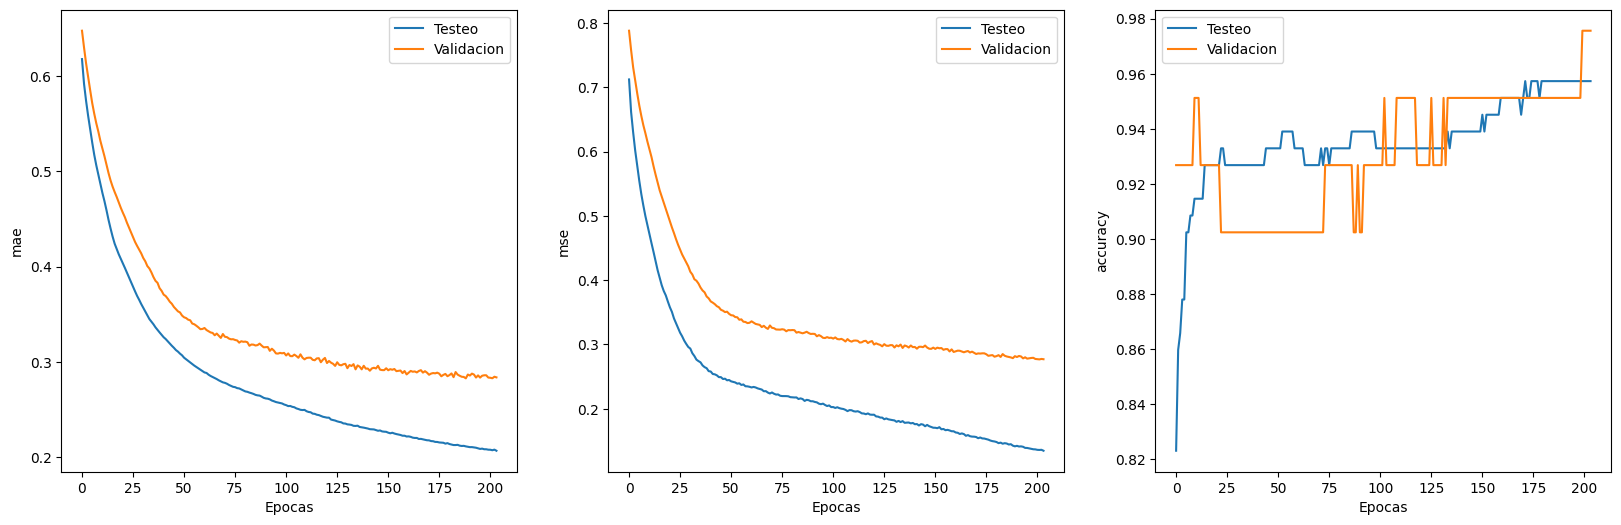

In [12]:
hist = history.history

def dibujar_curva(axs, value, epocas, hist):
    axs.plot(epocas, hist[value], label='Testeo')
    axs.plot(history.epoch, hist['val_'+value], label = 'Validacion')

    axs.set(xlabel="Epocas", ylabel=value)
    axs.legend()

fig, axs = plt.subplots(1,3, figsize=(20,6))

dibujar_curva(axs[0], 'mae', history.epoch, hist)
dibujar_curva(axs[1], 'mse', history.epoch, hist)
dibujar_curva(axs[2], 'accuracy', history.epoch, hist)

**Retroalimentación visual de las predicciones sobre los datos de validación**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[Text(0.5, 0, 'Ejemplo'), Text(0, 0.5, 'Precio del Vehículo')]

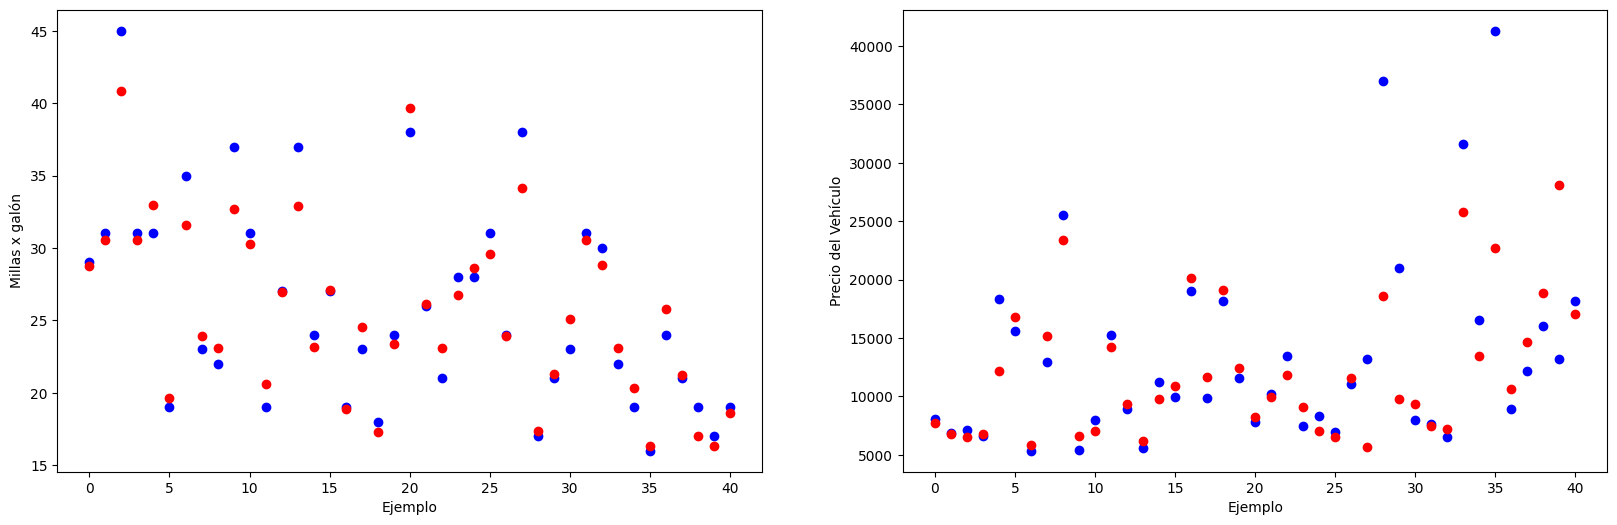

In [13]:
y_pred = model.predict(x_val)

y_val_no_norm = target_scaler.inverse_transform(y_val)
y_pred_no_norm = target_scaler.inverse_transform(y_pred)

fig, axs = plt.subplots(1,2, figsize=(20,6))

# lista con nro de iteracion
sample = list(range(len(y_val_no_norm)))

axs[0].plot(sample, y_val_no_norm[:,0],  "o", color='blue')
axs[0].plot(sample, y_pred_no_norm[:,0], "o", color='red')
axs[0].set(xlabel='Ejemplo', ylabel='Millas x galón')

axs[1].plot(sample, y_val_no_norm[:,1],  "o", color='blue')
axs[1].plot(sample, y_pred_no_norm[:,1], "o", color='red')
axs[1].set(xlabel='Ejemplo', ylabel='Precio del Vehículo')